In [179]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [180]:
class StochasticOscillator:
    def __init__(self, data, sma, symbol) : 
        self.symbol = symbol
        self.data = data
        self.sma = sma

        self.sma = self.sma[~np.isnan(self.sma)]
        self.data = self.data.iloc[len(self.data) - len(self.sma):]


        self.best_order, self.df = self._get_optimal_reversal_order(data['Close'].values)
        self.df_swings = self._identify_swings(self.data.copy(), self.best_order)
        self.swing_distances = self._get_swing_distances(self.df_swings)

        self.macro_order = None
        self.full_cycle_order = None

    
    # ======================
    # 🔧 Utility Functions
    # ======================

    # Hitung SNR, ACF, dan deteksi titik reversal untuk berbagai order sehingga didapatkan order optimal
    def _get_acf(self, series, lag):
        n = len(series)
        mean = np.mean(series)
        var = np.var(series)
        cov = np.sum((series[:-lag] - mean) * (series[lag:] - mean)) / (n - lag)
        return cov / var if var != 0 else 0

    def _detect_turning_points(self, data):
        # Titik reversal terjadi ketika slope berubah tanda
        diff = np.diff(data)
        signs = np.sign(diff)
        reversals = np.where(np.diff(signs) != 0)[0]
        if len(reversals) < 2:
            return np.nan
        return np.mean(np.diff(reversals))

    def _get_optimal_reversal_order(self, close_prices, max_order=30):
        results = []

        for order in range(2, max_order + 1):
            # 1️⃣ SNR
            min_len = min(len(close_prices[order-1:]), len(self.sma))
            noise = close_prices[order-1:order-1+min_len] - self.sma[-min_len:]
            var_signal = np.var(self.sma)
            var_noise = np.var(noise)
            snr = var_signal / var_noise if var_noise != 0 else 0

            # 2️⃣ ACF (pada lag = order)
            returns = np.diff(np.log(close_prices))
            acf_val = self._get_acf(returns, min(order, len(returns)-1))

            # 3️⃣ Turning Point Distance
            avg_turn = self._detect_turning_points(self.sma)

            # Skor kombinasi (kita ingin SNR tinggi, ACF moderat+, dan avg_turn kecil tapi stabil)
            composite_score = (snr * (abs(acf_val) + 1e-5)) / (avg_turn + 1e-5)
            results.append({
                'order': order,
                'snr': snr,
                'acf': acf_val,
                'avg_turn': avg_turn,
                'score': composite_score
            })

        df = pd.DataFrame(results).dropna().sort_values('score', ascending=False)
        best = df.iloc[0]

        # print(df[['order','snr','acf','avg_turn','score']].head(10))
        print(f"\n✅ Order optimal (berdasarkan SNR+ACF+Reversal): {int(best['order'])}")
        print(f"   • SNR  = {best['snr']:.4f}")
        print(f"   • ACF  = {best['acf']:.4f}")
        print(f"   • Avg reversal cycle ≈ {best['avg_turn']:.2f} candle")

        return int(best['order']), df

        # Identifikasi Swing High dan Swing Low
    
    def _identify_swings(self, df, order):
        for i in range(order, len(df) - order):
            high_window = df['High'].iloc[i-order:i+order+1]
            low_window = df['Low'].iloc[i-order:i+order+1]
            
            if df['High'].iloc[i] == high_window.max():
                df.at[df.index[i], 'Swing_High'] = True
            if df['Low'].iloc[i] == low_window.min():
                df.at[df.index[i], 'Swing_Low'] = True
        return df

    # Menghitung jarak antar swing high, swing low, dan swing kombinasi
    def _get_swing_distances(self, btc_swings):
        """
        Menghitung rata-rata jarak antar swing high, swing low, dan swing kombinasi (any)
        dari DataFrame yang berisi kolom boolean 'Swing_High' dan 'Swing_Low'.
        
        Returns:
            dict: {
                'avg_high_distance': float,
                'avg_low_distance': float,
                'avg_any_distance': float
            }
        """
        # Konversi dulu ke Series bertipe nullable boolean
        btc_swings['Swing_High'] = pd.Series(btc_swings['Swing_High'], dtype='boolean')
        btc_swings['Swing_Low']  = pd.Series(btc_swings['Swing_Low'], dtype='boolean')

        # Baru isi NaN dengan False (aman, tanpa downcasting)
        btc_swings['Swing_High'] = btc_swings['Swing_High'].fillna(False)
        btc_swings['Swing_Low']  = btc_swings['Swing_Low'].fillna(False)

        # Buat posisi indeks
        positions = np.arange(len(btc_swings))

        # Ambil posisi tiap swing
        swing_high_pos = positions[btc_swings['Swing_High']].tolist()
        swing_low_pos  = positions[btc_swings['Swing_Low']].tolist()
        swing_any_pos  = positions[(btc_swings['Swing_High'] | btc_swings['Swing_Low'])].tolist()


        # Hitung jarak antar swing
        high_distances = [j - i for i, j in zip(swing_high_pos[:-1], swing_high_pos[1:])]
        low_distances  = [j - i for i, j in zip(swing_low_pos[:-1], swing_low_pos[1:])]
        any_distances  = [j - i for i, j in zip(swing_any_pos[:-1], swing_any_pos[1:])]

        # Rata-rata jarak (None jika tidak ada data)
        avg_high_distance = np.mean(high_distances) if high_distances else None
        avg_low_distance  = np.mean(low_distances) if low_distances else None
        avg_any_distance  = np.mean(any_distances) if any_distances else None

        self.macro_order = avg_any_distance
        self.full_cycle_order = avg_high_distance

        # Cetak hasil
        print(f"\n📈 Rata-rata jarak antar Swing High (Full Cycle): {self.full_cycle_order:.2f} candles")
        print(f"📉 Rata-rata jarak antar Swing Low  (Full Cycle): {avg_low_distance:.2f} candles")
        print(f"🔁 Rata-rata jarak antar Swing (Makro):          {self.macro_order:.2f} candles\n")

    # Menghitung %K Smoothing
    def _find_k_smoothing(self, n):
        max_smoothing = 5

        # Hitung %K raw secara lokal
        high_n = self.data['High'].rolling(n).max()
        low_n  = self.data['Low'].rolling(n).min()
        k_raw = 100 * (self.data['Close'] - low_n) / (high_n - low_n)

        # Hitung range per candle
        range_n = high_n - low_n

        # Threshold objektif epsilon
        epsilon = (self.data['Close'].diff().abs() / range_n).mean()

        # Cari smoothing
        for t in range(1, max_smoothing + 1):
            k_smooth_candidate = k_raw.rolling(t).mean()
            ratio = k_smooth_candidate.std() / range_n.mean()
            if ratio <= epsilon:
                k_smooth = t
                break
        else:
            k_smooth = 1  # fallback jika tidak ada yang memenuhi

        # Tambahkan %K_smooth ke dataframe
        k_smooth = k_raw.rolling(k_smooth).mean()

        return k_smooth

    # Mencari %D Smoothing
    def _find_d_smoothing(self, k_smooth_series):
        max_smoothing = 5

        # Gunakan data dari objek class
        high_n = self.data['High'].rolling(self.best_order).max()
        low_n  = self.data['Low'].rolling(self.best_order).min()
        range_n = high_n - low_n

        # Threshold minor fluktuasi
        epsilon_D = (k_smooth_series.diff().abs() / range_n).mean()

        # Cari smoothing untuk %D
        for t in range(1, max_smoothing + 1):
            d_candidate = k_smooth_series.rolling(t).mean()
            ratio = d_candidate.std() / range_n.mean()
            if ratio <= epsilon_D:
                return t  # kembalikan nilai smoothing terbaik (integer)
        
        return 1  # fallback jika tidak ada yang memenuhi


    def plot_stochastic_oscillator(self, kk_length):

        """
        Menampilkan grafik Stochastic Oscillator (%K dan %D)
        dengan area overbought/oversold dan label parameter dinamis.

        Parameters
        ----------
        data : pd.DataFrame
            Data OHLCV (harus memiliki kolom 'High', 'Low', 'Close')
        k_length : int
            Panjang periode utama untuk %K (misal: 14)
        k_smooth : int
            Panjang smoothing untuk %K (misal: 3)
        d_smooth : int
            Panjang smoothing untuk %D (misal: 3)
        title_suffix : str, optional
            Tambahan judul (misal nama aset)
        """

        k_length = self.best_order
        k_smooth = self._find_k_smoothing(k_length)
        d_smooth = self._find_d_smoothing(k_smooth)
        title_suffix = self.symbol

        df = self.data.copy()

        # Hitung rolling high/low
        low_n = df['Low'].rolling(window=k_length).min()
        high_n = df['High'].rolling(window=k_length).max()

        # Fast %K
        df['%K_fast'] = 100 * ((df['Close'] - low_n) / (high_n - low_n))

        # Slow %K dan %D
        df['%K'] = df['%K_fast'].rolling(window=int(np.nanmean(k_smooth))).mean()
        df['%D'] = df['%K'].rolling(window=int(np.nanmean(d_smooth))).mean()


        # Label dinamis
        label_k = f'%K ({k_length})'
        label_d = f'%D ({d_smooth})'

        # === Plot ===
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df['%K'], label=label_k, color='blue', linewidth=1.5)
        plt.plot(df.index, df['%D'], label=label_d, color='red', linewidth=1.5)

        # Area overbought/oversold
        plt.axhline(80, color='gray', linestyle='--', linewidth=1)
        plt.axhline(20, color='gray', linestyle='--', linewidth=1)
        plt.fill_between(df.index, 80, 100, color='red', alpha=0.1)
        plt.fill_between(df.index, 0, 20, color='green', alpha=0.1)

        plt.title(f'Stochastic Oscillator {title_suffix} ({k_length}, {k_smooth}, {d_smooth})')
        plt.ylabel('Stochastic (%)')
        plt.xlabel('Tanggal')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        return plt.show()




In [181]:
def fetch_crypto_data(ticker="BTC-USD", period="1y", interval="1d"):
    """
    Mengambil data harga crypto dari Yahoo Finance.
    
    Args:
        ticker (str): simbol crypto, default BTC-USD
        period (str): periode data, contoh '1y', '5y', '6mo'
        interval (str): interval data, contoh '1d', '1h', '1wk'
        
    Returns:
        pd.DataFrame: DataFrame berisi High, Low, Close, Open, Volume, Return
    """
    data = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    
    # Pilih kolom yang relevan dan drop missing
    data = data[['High', 'Low', 'Close', 'Open', 'Volume']].dropna()
    
    # Jika kolom multiindex, ambil level pertama
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    # Hitung return harian/log return
    data['Return'] = data['Close'].pct_change()
    
    return data

def get_volatility_ratio(data):
    return data['Close'].std() / data['Close'].mean() * 100

def get_sma(data, order) : 
    # Menghitung simple moving average (SMA) dengan order tertentu
    return np.convolve(data, np.ones(order)/order, mode='valid')

# Plot Stochastic Oscillator
def plot_stochastic_oscillator(data, k_length:int, k_smooth:int, d_smooth:int, title_suffix:str="BTC-USD"):

    """
    Menampilkan grafik Stochastic Oscillator (%K dan %D)
    dengan area overbought/oversold dan label parameter dinamis.

    Parameters
    ----------
    data : pd.DataFrame
        Data OHLCV (harus memiliki kolom 'High', 'Low', 'Close')
    k_length : int
        Panjang periode utama untuk %K (misal: 14)
    k_smooth : int
        Panjang smoothing untuk %K (misal: 3)
    d_smooth : int
        Panjang smoothing untuk %D (misal: 3)
    title_suffix : str, optional
        Tambahan judul (misal nama aset)
    """

    df = data.copy()

    # Hitung rolling high/low
    low_n = df['Low'].rolling(window=k_length).min()
    high_n = df['High'].rolling(window=k_length).max()

    # Fast %K
    df['%K_fast'] = 100 * ((df['Close'] - low_n) / (high_n - low_n))

    # Slow %K dan %D
    df['%K'] = df['%K_fast'].rolling(window=k_smooth).mean()
    df['%D'] = df['%K'].rolling(window=d_smooth).mean()

    # Label dinamis
    label_k = f'%K ({k_length})'
    label_d = f'%D ({d_smooth})'

    # === Plot ===
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['%K'], label=label_k, color='blue', linewidth=1.5)
    plt.plot(df.index, df['%D'], label=label_d, color='red', linewidth=1.5)

    # Area overbought/oversold
    plt.axhline(80, color='gray', linestyle='--', linewidth=1)
    plt.axhline(20, color='gray', linestyle='--', linewidth=1)
    plt.fill_between(df.index, 80, 100, color='red', alpha=0.1)
    plt.fill_between(df.index, 0, 20, color='green', alpha=0.1)

    plt.title(f'Stochastic Oscillator {title_suffix} ({k_length}, {k_smooth}, {d_smooth})')
    plt.ylabel('Stochastic (%)')
    plt.xlabel('Tanggal')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    return plt.show()

def view_stochastic_oscillator(data, k_length_full_cycle, k_length_macro, k_length_best_order, title) :

    k_smooth_full_cycle = max(find_k_smoothing(data, k_length_full_cycle), 3)
    k_smooth_macro = max(find_k_smoothing(data, k_length_macro), 3)
    k_smooth_best_order = max(find_k_smoothing(data, k_length_best_order), 3)

    d_smooth_full_cycle = max(find_d_smoothing(data, k_smooth_full_cycle), 3)
    d_smooth_macro = max(find_d_smoothing(data, k_smooth_macro), 3)
    d_smooth_best_order = max(find_d_smoothing(data, k_smooth_best_order), 3)

    # Plot Stoch Full Cycle
    plot_stochastic_oscillator(data, k_length_full_cycle, k_smooth_full_cycle, d_smooth_full_cycle, title_suffix=f"{title} Full Cycle")

    # Plot Stoch Makro
    plot_stochastic_oscillator(data, k_length_macro, k_smooth_macro, d_smooth_macro, title_suffix=f"{title} Macro")

    # Plot Stoch Best Order
    plot_stochastic_oscillator(data, k_length_best_order, k_smooth_best_order, d_smooth_best_order, title_suffix=f"{title} Best Order")




✅ Order optimal (berdasarkan SNR+ACF+Reversal): 9
   • SNR  = 28.4267
   • ACF  = 0.0781
   • Avg reversal cycle ≈ 7.17 candle

📈 Rata-rata jarak antar Swing High (Full Cycle): 27.27 candles
📉 Rata-rata jarak antar Swing Low  (Full Cycle): 25.36 candles
🔁 Rata-rata jarak antar Swing (Makro):          13.35 candles



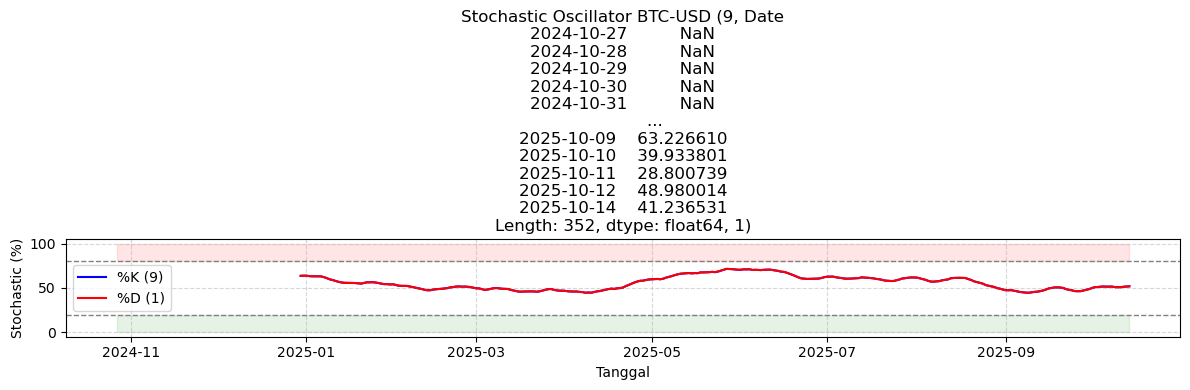

In [182]:
# === Ambil data BTC daily selama 1 tahun ===
btc_data = fetch_crypto_data()
btc_sma = get_sma(btc_data['Close'].values, 14)

stoch = StochasticOscillator(btc_data, btc_sma, "BTC-USD")
stoch.plot_stochastic_oscillator(stoch.best_order)

